# Segmentation of Indian Traffic

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

In [ ]:
!gdown --id 1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2231M  100 2231M    0     0   143M      0  0:00:15  0:00:15 --:--:--  160M


In [ ]:
!unzip -q data.zip

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    columns = ['image','json']
    data_df = pd.DataFrame()
    k=0
    for i in sorted(os.listdir(root_dir)):
        for root, dirs, files in os.walk(root_dir+'/'+i):
            dirs.sort()
            arr = []
            for dir in dirs:
                files = os.listdir(path.join(root,dir))
                files.sort()
                for name in files:
                    arr.append(path.join(root,dir,name))
            break
        data_df[columns[k]] = arr
        k+=1
    
    return data_df

In [ ]:
os.listdir('data')

['images', 'mask']

In [ ]:
data_df = return_file_names_df('data')
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


> If observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png'>

* Each File has 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object has multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.

In [ ]:
def return_unique_labels(data_df):

    arr = []
    # for each file in the column json
    for i in data_df['json'].values:
    #       read and store all the objects present in that file
        f = open(i)
        data = json.load(f)
        f.close()
        for j in data['objects']:
            arr.append(j['label'])
    # compute the unique objects and retrun them
    unique_labels = set(arr)
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    label, vertexlist = [], []
    f = open(file)
    data = json.load(f)
    f.close()
    for i in data['objects']:
        arr = []
        label.append(i['label'])
        for j in i['polygon']:
            arr.append(tuple(j))
        vertexlist.append(arr)

    h = data['imgHeight']
    w = data['imgWidth']

    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

In [ ]:
def compute_masks(data_df):
    # after we have computed the vertexlist plot that polygone in image like this
    mask_paths = []
    for file in tqdm(data_df['json'].values):
        w, h, labels, vertexlist = get_poly(file)
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for i in range(len(vertexlist)):
            if(len(vertexlist[i]) > 1):
                img1.polygon(vertexlist[i], fill = label_clr[labels[i]])
        
        # after drawing all the polygons that we collected from json file, 
        # we need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        if not os.path.isdir('data/output'):
            os.makedirs('data/output')
        if not os.path.isdir('data/output/'+file.split('/')[2]):
            os.makedirs('data/output/'+file.split('/')[2])
        location = path.join('data/output',file.split('/')[2],file.split('/')[3].split('.')[0]+'.png')
        im.save(location)

        # after saving the image into disk, store the path in a list
        # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
        mask_paths.append(location)
    data_df['mask']= mask_paths
    
    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [04:34<00:00, 14.60it/s]


,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

In [ ]:
data_df = pd.read_csv('preprocessed_data.csv')

In [ ]:
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


### Task 2.1: Dice loss


* Dice loss
* 1. Formualtion

   ${D} = \frac{ 2 \sum \limits _{i=1} ^{N} {p}_{i} {g}_{i}} {\sum \limits _{i=1} ^{N} {p}_{i}^{2} + \sum \limits _{i=1} ^{N} {g}_{i}^{2}} $ 
 
* 2. Range of the loss function

range is between 0 and 1.
* 3. Interpretation of loss function

Here, pi and gi are prediction and corresponding ground truth pixel values respectively.
* 4. understanding of the loss function

 The overlap between ground truth and predicted pixel masks is given the most importance. If there is perfect overlap then Dice loss will be maximum (i.e. 1) and if there is no overlap loss will be minimum (i.e. 0). 
This loss is calculated for each class mask separately and the total loss is calculated by averaging over all class mask losses.
Since Dice loss is a loss maximizing problem, we can calculate (1-Dice loss) to pose it as a loss minimizing problem.

Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.1, random_state=42)

In [ ]:
import tensorflow as tf
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
import imgaug.augmenters as iaa
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()
    
def normalize_image(mask):
    mask = mask/255
    return mask

class Dataset:
    # we will be modifying this CLASSES according to our data/problems
    CLASSES = ['edited','non-edited']
    
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, file_names, classes,type):
        
        self.w = 256
        self.h = 256
        # the paths of images
        self.images_fps   = file_names['image'].values
        # the paths of segmentation images
        self.masks_fps    = file_names['mask'].values
        # giving labels for each class
        self.class_values = classes
        self.type = type
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_NEAREST)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = normalize_image(image)

        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED) 
        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_NEAREST)

        
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
   
        if self.type == 'train':
            a = np.random.uniform()
            if a<0.2:
                image = aug2.augment_image(image)
                image_mask = aug2.augment_image(image_mask)
            elif a<0.4:
                image = aug3.augment_image(image)
                image_mask = aug3.augment_image(image_mask)
            elif a<0.6:
                image = aug4.augment_image(image)
                image_mask = aug4.augment_image(image_mask)
            elif a<0.8:
                image = aug5.augment_image(image)
                image_mask = image_mask
            else:
                image = aug6.augment_image(image)
                image_mask = aug6.augment_image(image_mask)
            
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
#total_loss = sm.losses.categorical_focal_dice_loss 
iou_score.threshold = 0.5

model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
train_dataset = Dataset(X_train, list(np.unique(list(label_clr.values()))), 'train')
test_dataset  = Dataset(X_test, list(np.unique(list(label_clr.values()))), 'val')

BATCH_SIZE=5
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(train_dataloader[0][0].shape)
assert train_dataloader[0][0].shape == (BATCH_SIZE, 256, 256, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 256, 256, 21)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score',patience=2),
]

(5, 256, 256, 3)


In [ ]:
history = model.fit(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=4,\
                              validation_data=test_dataloader,callbacks=callbacks, )

Epoch 1/4
721/721 [==============================] - 346s 471ms/step - loss: 0.9010 - iou_score: 0.3508 - val_loss: 0.8824 - val_iou_score: 0.3656 - lr: 1.0000e-04
Epoch 2/4
721/721 [==============================] - 341s 473ms/step - loss: 0.7359 - iou_score: 0.4803 - val_loss: 0.7162 - val_iou_score: 0.4969 - lr: 1.0000e-04
Epoch 3/4
721/721 [==============================] - 342s 474ms/step - loss: 0.6599 - iou_score: 0.5398 - val_loss: 0.6524 - val_iou_score: 0.5347 - lr: 1.0000e-04
Epoch 4/4
721/721 [==============================] - 339s 470ms/step - loss: 0.6064 - iou_score: 0.5847 - val_loss: 0.6329 - val_iou_score: 0.5507 - lr: 1.0000e-05


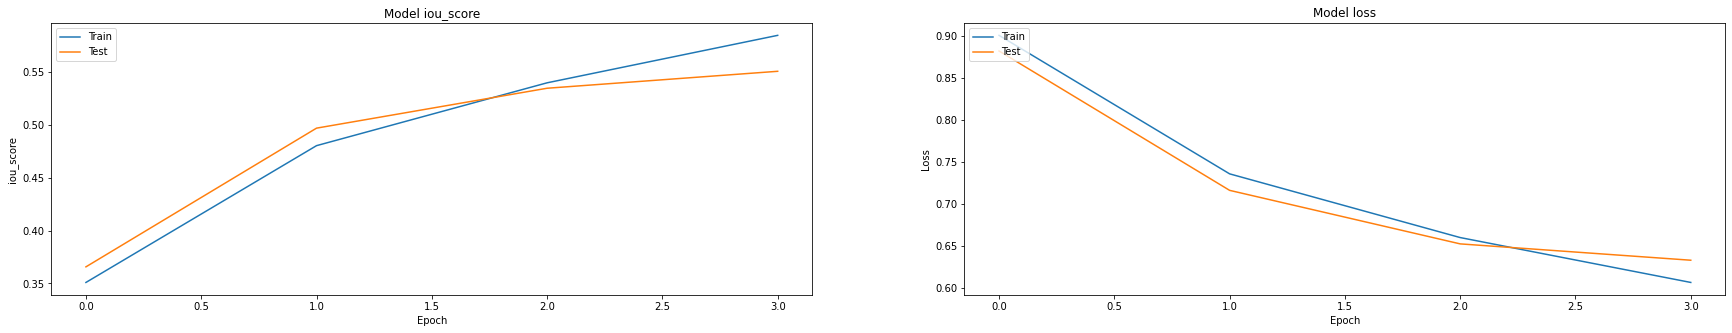

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
X_test

,image,json,mask
2580,data/images/347/frame6101_leftImg8bit.jpg,data/mask/347/frame6101_gtFine_polygons.json,data/output/347/frame6101_gtFine_polygons.png
3659,data/images/406/frame0881_leftImg8bit.jpg,data/mask/406/frame0881_gtFine_polygons.json,data/output/406/frame0881_gtFine_polygons.png
897,data/images/252/frame1964_leftImg8bit.jpg,data/mask/252/frame1964_gtFine_polygons.json,data/output/252/frame1964_gtFine_polygons.png
2091,data/images/315/frame3947_leftImg8bit.jpg,data/mask/315/frame3947_gtFine_polygons.json,data/output/315/frame3947_gtFine_polygons.png
1044,data/images/262/frame0653_leftImg8bit.jpg,data/mask/262/frame0653_gtFine_polygons.json,data/output/262/frame0653_gtFine_polygons.png
...,...,...,...
2509,data/images/338/frame66144_leftImg8bit.jpg,data/mask/338/frame66144_gtFine_polygons.json,data/output/338/frame66144_gtFine_polygons.png
655,data/images/237/frame6434_leftImg8bit.jpg,data/mask/237/frame6434_gtFine_polygons.json,data/output/237/frame6434_gtFine_polygons.png
2964,data/images/372/frame1608_leftImg8bit.jpg,data/mask/372/frame1608_gtFine_polygons.json,data/output/372/frame1608_gtFine_polygons.png
1740,data/images/302/frame12437_leftImg8bit.jpg,data/mask/302/frame12437_gtFine_polygons.json,data/output/302/frame12437_gtFine_polygons.png


0 data/images/347/frame6101_leftImg8bit.jpg
(256, 256)


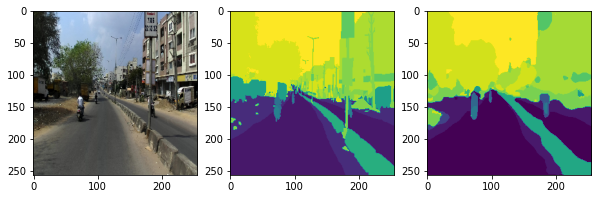

1 data/images/406/frame0881_leftImg8bit.jpg
(256, 256)


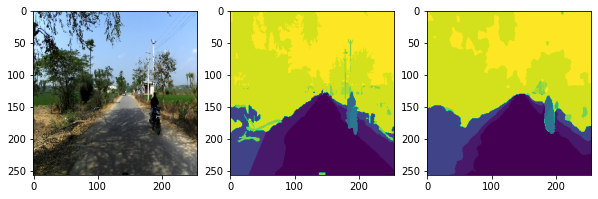

2 data/images/252/frame1964_leftImg8bit.jpg
(256, 256)


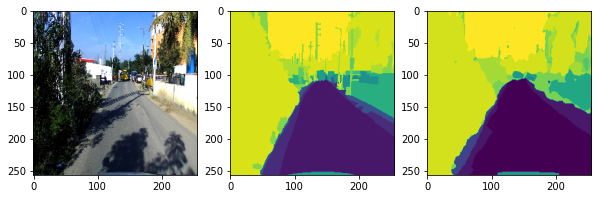

3 data/images/315/frame3947_leftImg8bit.jpg
(256, 256)


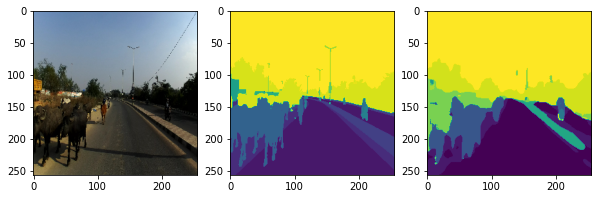

4 data/images/262/frame0653_leftImg8bit.jpg
(256, 256)


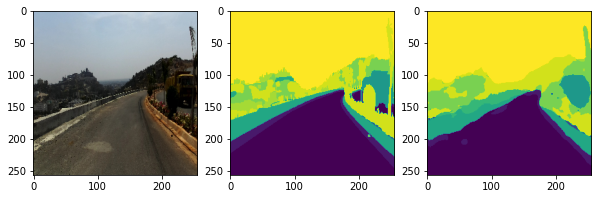

5 data/images/333/frame1217_leftImg8bit.jpg
(256, 256)


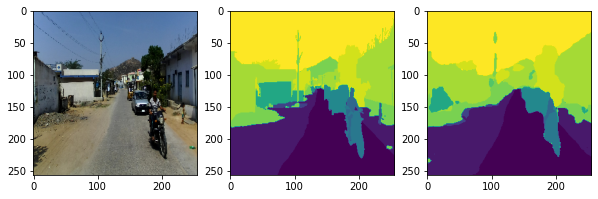

6 data/images/233/frame1002_leftImg8bit.jpg
(256, 256)


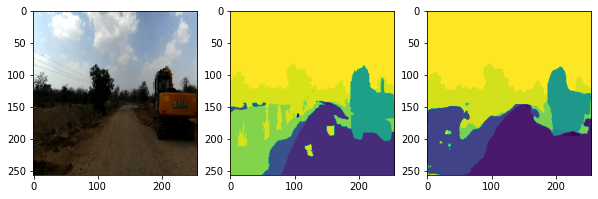

7 data/images/213/frame18369_leftImg8bit.jpg
(256, 256)


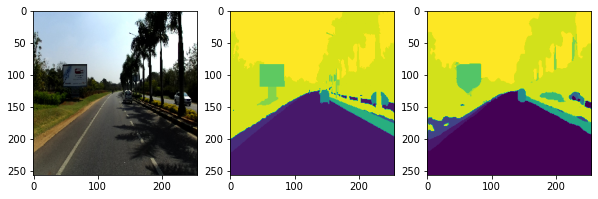

8 data/images/421/0003527_leftImg8bit.jpg
(256, 256)


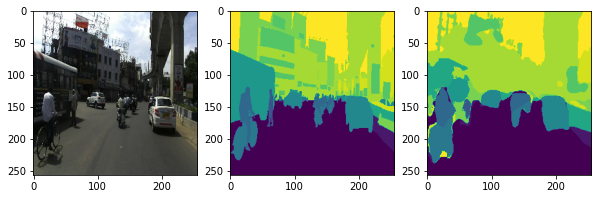

9 data/images/387/frame5281_leftImg8bit.jpg
(256, 256)


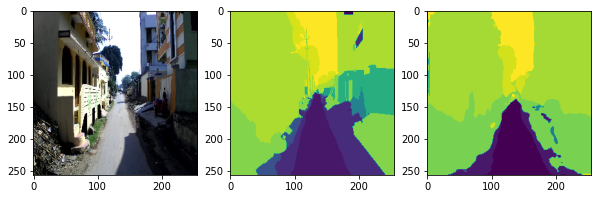

10 data/images/206/frame0839_leftImg8bit.jpg
(256, 256)


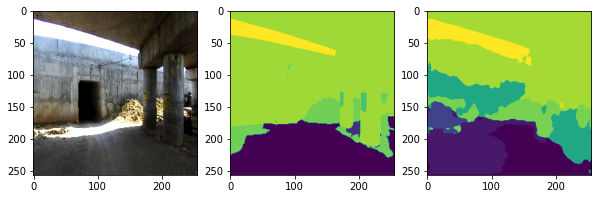

11 data/images/377/frame3609_leftImg8bit.jpg
(256, 256)


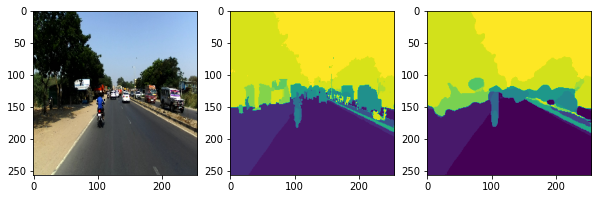

12 data/images/314/frame10014_leftImg8bit.jpg
(256, 256)


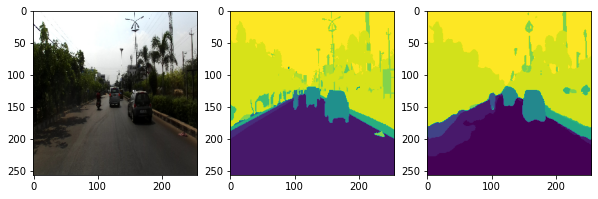

13 data/images/338/frame53026_leftImg8bit.jpg
(256, 256)


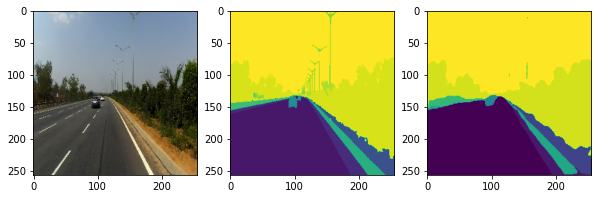

14 data/images/357/frame11382_leftImg8bit.jpg
(256, 256)


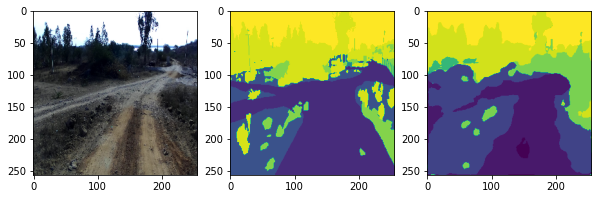

15 data/images/417/0006252_leftImg8bit.jpg
(256, 256)


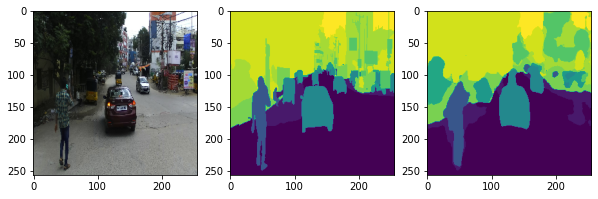

16 data/images/285/frame2586_leftImg8bit.jpg
(256, 256)


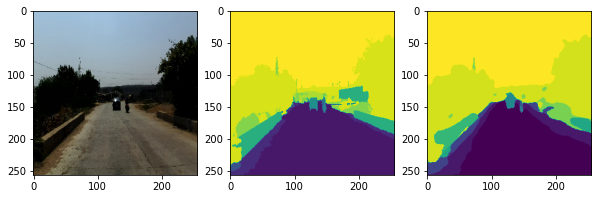

17 data/images/419/frame1979_leftImg8bit.jpg
(256, 256)


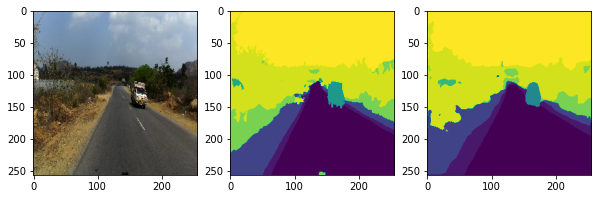

18 data/images/322/frame1949_leftImg8bit.jpg
(256, 256)


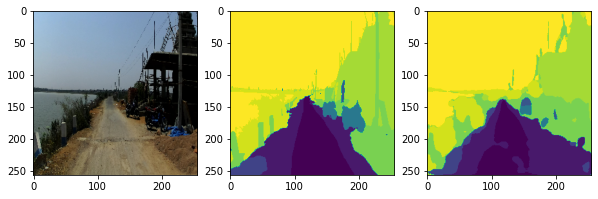

19 data/images/209/frame4492_leftImg8bit.jpg
(256, 256)


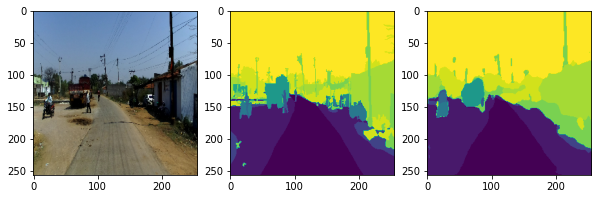

In [ ]:
for p, i in enumerate(X_test['image'].values[:20]):
    #original image
    print(p,i)
    image = cv2.imread(i, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    nor_image = normalize_image(image) 
    
    #predicted segmentation map
    predicted  = model.predict(nor_image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(X_test['mask'].values[p], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256),interpolation=cv2.INTER_NEAREST)

    print(image_mask.shape)
    
    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.show()